In [37]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline
import seaborn as sns
sns.set_theme()

In [38]:
## Define functions

def parameters_to_global_variables(Parameters):
# reads input parameters from dictionary and assigns them as global variables with variablels  names same as the dict keys
    keys = list(Parameters.keys())
    for i in keys:
        globals()[i] = Parameters[i]

def initialize():
    # trait [0] = M01, trait [1] = M10
    # free-floating state in host
    H0 = np.array([[], [], []])
    # bound state in host
    H1 = np.array([[], [], []])
    # external environment state
    E = np.array([[0] * KE, [1] * KE, np.random.random(KE).tolist()])

    return (H0, H1, E)


def flow(H0, E):
    migHE = np.array([[], [], []])
    migEH = np.array([[], [], []])
    idxHE = []
    idxEH = []
    NH = len(H0[0])
    NE = len(E[0])

    if NH != 0:
        # number of emigrants
        mHE = int(np.floor(mH * NH))
        # indices of emigrants
        idxHE = random.sample(range(NH), min(mHE, NH))
        migHE = np.c_[migHE, H0[:, idxHE]]
    if NE != 0:
        # number of immigrants
        mEH = int(np.floor(mH * KH * NE / KE))
        # indices of emigrants
        idxEH = random.sample(range(NE), min(mEH, NE))
        migEH = np.c_[migEH, E[:, idxEH]]
    # remove and add migrants
    H0 = np.delete(H0, idxHE, axis=1)
    H0 = np.c_[H0, migEH]
    E = np.delete(E, idxEH, axis=1)
    E = np.c_[E, migHE]

    return (H0, E)


def adhesion(H0, H1):
    mig01 = np.array([[], [], []])
    mig10 = np.array([[], [], []])
    idx01 = []
    idx10 = []
    NH0 = len(H0[0])
    NH1 = len(H1[0])

    if NH0 != 0:
        prob01 = np.random.random(NH0)
        idx01 = [i for i in range(NH0) if prob01[i] < H0[0][i]]
        mig01 = np.c_[mig01, H0[:, idx01]]
    if NH1 != 0:
        prob10 = np.random.random(NH1)
        idx10 = [i for i in range(NH1) if prob10[i] < H1[1][i]]
        mig10 = np.c_[mig10, H1[:, idx10]]

    H0 = np.delete(H0, idx01, axis=1)
    H0 = np.c_[H0, mig10]
    H1 = np.delete(H1, idx10, axis=1)
    H1 = np.c_[H1, mig01]

    return (H0, H1)
    
def selection_in_host(H0, H1):
    NH0 = len(H0[0])
    NH1 = len(H1[0])
    NH = NH0 + NH1
    p0 = 1 - NH/KH
    p1 = p0 - w
        
    if NH0 != 0:
        prob0 = np.random.random(NH0)
        if p0 >= 0:
            idx0 = [i for i in range(NH0) if prob0[i]<p0]
            mutations = np.random.normal(0, mu, size=(2,len(idx0))).round(2)
            offs = np.clip(H0[:,idx0] + mutations, 0, 1)
            H0 = np.c_[H0, offs]
        else:
            idx0 = [i for i in range(NH0) if prob0[i]<-p0]
            H0 = np.delete(H0, idx0, axis=1)
        
    if NH1 != 0:
        prob1 = np.random.random(NH1)
        if p1 >= 0:
            idx1 = [i for i in range(NH1) if prob1[i]<p1]
            mutations = np.random.normal(0, mu, size=(2,len(idx1))).round(2)
            offs = np.clip(H1[:,idx1] + mutations, 0, 1)
            H1 = np.c_[H1, offs]
        else:
            idx1 = [i for i in range(NH1) if prob1[i]<-p1]
            H1 = np.delete(H1, idx1, axis=1)
        
    return(H0, H1)

def env_dynamics(E):
    NE = len(E[0])
    if NE!=0:
        p = 1 - NE/KE
        prob = np.random.random(NE)
        if p>0:
            idx = [i for i in range(NE) if prob[i]<p]
            mutations = np.random.normal(0, mu, size=(2,len(idx))).round(2)
            offs = np.clip(E[:,idx] + mutations, 0, 1)
            E = np.c_[E, offs]
        else:
            idx = [i for i in range(NE) if prob[i]<-p]
            E = np.delete(E, idx, axis=1)
    return(E)

def selection_new(H0, H1, E):
    NH0 = len(H0[0])
    NH1 = len(H1[0])

    if NH0 != 0:
        prob0 = np.random.random(size=(2,NH0))
        idx0b = [i for i in range(NH0) if prob0[0][i] < H0[2][i]]
        mutations = np.random.normal(0, mu, size=(3, len(idx0b))).round(2)
        offs = np.clip(H0[:, idx0b] + mutations, 0, 1)
        idx0d = [i for i in range(NH0) if prob0[1][i] < d]
        H0 = np.delete(H0, idx0d, axis=1)
        H0 = np.c_[H0, offs]

    if NH1 != 0:
        prob1 = np.random.random(size=(2,NH1))
        idx1b = [i for i in range(NH1) if prob1[0][i] < (1-w)*H1[2][i]]
        mutations = np.random.normal(0, mu, size=(3, len(idx1b))).round(2)
        offs = np.clip(H1[:, idx1b] + mutations, 0, 1)
        idx1d = [i for i in range(NH1) if prob1[1][i] < d]
        H1 = np.delete(H1, idx1d, axis=1)
        H1 = np.c_[H1, offs]

    NE = len(E[0])
    if NE != 0:
        prob = np.random.random(size=(2,NE))
        idxb = [i for i in range(NE) if prob[0][i] < 1 - E[2][i]]
        mutations = np.random.normal(0, mu, size=(3, len(idxb))).round(2)
        offs = np.clip(E[:, idxb] + mutations, 0, 1)
        idxd = [i for i in range(NE) if prob[1][i] < d]
        E = np.delete(E, idxd, axis=1)
        E = np.c_[E, offs]

    return(H0, H1, E)

def cap(H0, H1, E):
    NH0 = len(H0[0])
    NH1 = len(H1[0])
    NH = NH0 + NH1
    NE = len(E[0])

    if NH > KH:
        ndel = NH - KH
        idx = random.sample(range(NH),ndel)
        idx0 = [i for i in idx if i<NH0]
        idx1 = [i-NH0 for i in idx if i>=NH0]
        H0 = np.delete(H0, idx0, axis=1)
        H1 = np.delete(H1, idx1, axis=1)

    if NE > KE:
        ndel = NE - KE
        idx = random.sample(range(NE),ndel)
        E = np.delete(E, idx, axis=1)

    return(H0, H1, E)

In [18]:
## run one simulation
        
def run_one_sim(Parameters):
    # read parameters
    parameters_to_global_variables(Parameters)
    
    H0, H1, E = initialize()
    data = []
    for t in range(sim_time):
        vrand = random.random()
        if vrand < v:
            H0, E = flow(H0, E)
        H0, H1 = adhesion(H0, H1)
        H0, H1 = selection_in_host(H0, H1)
        E = env_dynamics(E)
        data.append([len(H1[0]), len(H0[0]), len(E[0]), np.histogram(H0[0],bins=20, range=(0,1))[0], 
                     np.histogram(H1[0],bins=20, range=(0,1))[0],
                     np.histogram(E[0],bins=20, range=(0,1))[0],
                     np.histogram(H0[1],bins=20, range=(0,1))[0],
                     np.histogram(H1[1],bins=20, range=(0,1))[0],
                     np.histogram(E[1],bins=20, range=(0,1))[0]
                    ])
    return(data)

In [19]:
def run_one_sim_get_fracH1(Parameters):
    # read parameters
    parameters_to_global_variables(Parameters)
    
    H0, H1, E = initialize()
    data = []
    for t in range(sim_time):
        vrand = random.random()
        if vrand < v:
            H0, E = flow(H0, E)
        H0, H1 = adhesion(H0, H1)
        H0, H1 = selection_in_host(H0, H1)
        E = env_dynamics(E)
        NH = len(H0[0]) + len(H1[0])
        if NH==0:
            data.append(0)
        else:
            data.append(len(H1[0])/NH)
    return(data)

def run_one_sim_get_M(Parameters):
    # read parameters
    parameters_to_global_variables(Parameters)
    
    H0, H1, E = initialize()
    data = []
    for t in range(sim_time):
        vrand = random.random()
        if vrand < v:
            H0, E = flow(H0, E)
        H0, H1 = adhesion(H0, H1)
        H0, H1 = selection_in_host(H0, H1)
        E = env_dynamics(E)
        NH = len(H0[0]) + len(H1[0])
        if NH==0:
            data.append([0,0])
        else:
            data.append([np.mean(np.r_[H0[0],H1[0],E[0]]), np.mean(np.r_[H0[1],H1[1],E[1]])])
    return(data)

In [39]:
def run_one_sim_new(Parameters):
    # read parameters
    parameters_to_global_variables(Parameters)

    H0, H1, E = initialize()
    data = []
    for t in range(sim_time):
        vrand = random.random()
        if vrand < v:
            H0, E = flow(H0, E)
        H0, H1 = adhesion(H0, H1)
        H0, H1, E = selection_new(H0, H1, E)
        H0, H1, E = cap(H0, H1, E)
        data.append([len(H1[0]), len(H0[0]), len(E[0]), np.histogram(H0[0], bins=20, range=(0, 1))[0],
                     np.histogram(H1[0], bins=20, range=(0, 1))[0],
                     np.histogram(E[0], bins=20, range=(0, 1))[0],
                     np.histogram(H0[1], bins=20, range=(0, 1))[0],
                     np.histogram(H1[1], bins=20, range=(0, 1))[0],
                     np.histogram(E[1], bins=20, range=(0, 1))[0],
                     np.histogram(H0[2], bins=20, range=(0, 1))[0],
                     np.histogram(H1[2], bins=20, range=(0, 1))[0],
                     np.histogram(E[2], bins=20, range=(0, 1))[0]
                     ])
        print(t)
    return (data)

In [54]:
## Parameters

Parameters = {'KH': 50000,  # Carrying capacity in H
              'KE': 100000,  # Carrying capacity in environment
              'mH': 0.005,  # fraction of host matrix displaced during a flow event
              'v': 0.01,  # frequency of flow events
              'w': 0.1,  # magnitude of cost of adhesion to host
              'mu': 0.1,  # microbe mutation rate
              'sim_time': 500,  # total simulation time
              'd': 0.01  # probability of death
              }

data = run_one_sim_new(Parameters)
dat = pd.DataFrame(data, columns=['H1', 'H0', 'E', 'M01_H0', 'M01_H1', 'M01_E', 'M10_H0', 'M10_H1', 'M10_E',
                                  'rH_H0', 'rH_H1', 'rH_E'])
dat0 = dat[['H1', 'H0', 'E']]
dat01H0 = dat['M01_H0']
dat01H1 = dat['M01_H1']
dat01E = dat['M01_E']
dat10H0 = dat['M10_H0']
dat10H1 = dat['M10_H1']
dat10E = dat['M10_E']
datrH0 = dat['rH_H0']
datrH1 = dat['rH_H1']
datrE = dat['rH_E']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

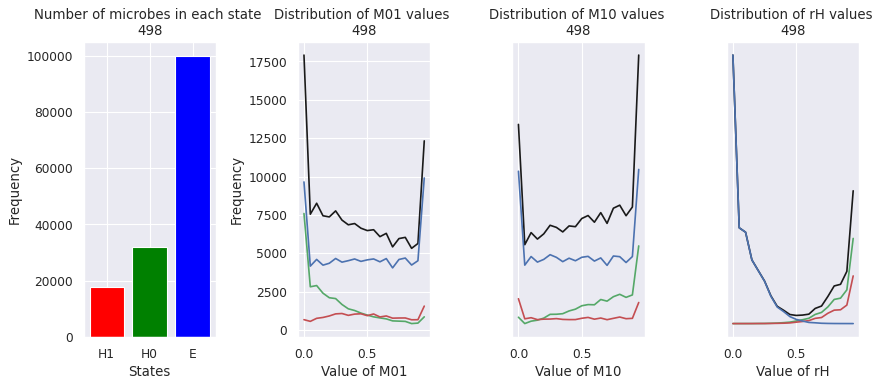

In [55]:
def buildmehist(i=int):
    iv = min(i*2, len(dat0.index) - 1)
    plt.clf()

    plt.subplot(141)
    objects = dat0.max().index
    y_pos = np.arange(len(objects))
    performance = dat0.iloc[[iv]].values.tolist()[0]
    plt.bar(y_pos, performance, align='center', color=['red', 'green', 'blue'])
    plt.xticks(y_pos, objects)
    plt.ylabel('Frequency')
    plt.xlabel('States')
    plt.title('Number of microbes in each state \n' + str(dat0.index[iv]))

    xval = np.arange(0, 1, 0.05)
    y01val = dat01H0[iv] + dat01H1[iv] + dat01E[iv]
    y10val = dat10H0[iv] + dat10H1[iv] + dat10E[iv]
    yrval = datrH0[iv] + datrH1[iv] + datrE[iv]
    ymax = max(np.r_[y01val, y10val, yrval])

    plt.subplot(142)
    plt.plot(xval, y01val, 'k')
    plt.plot(xval, dat01H0[iv], 'g')
    plt.plot(xval, dat01H1[iv], 'r')
    plt.plot(xval, dat01E[iv], 'b')
    plt.ylim = (0, ymax)
    plt.ylabel('Frequency')
    plt.xlabel('Value of M01')
    plt.title('Distribution of M01 values \n' + str(dat0.index[iv]))

    plt.subplot(143)
    plt.plot(xval, y10val, 'k')
    plt.plot(xval, dat10H0[iv], 'g')
    plt.plot(xval, dat10H1[iv], 'r')
    plt.plot(xval, dat10E[iv], 'b')
    plt.ylim = (0, ymax)
    plt.yticks([])
    plt.xlabel('Value of M10')
    plt.title('Distribution of M10 values \n' + str(dat0.index[iv]))

    plt.subplot(144)
    plt.plot(xval, yrval, 'k')
    plt.plot(xval, datrH0[iv], 'g')
    plt.plot(xval, datrH1[iv], 'r')
    plt.plot(xval, datrE[iv], 'b')
    plt.ylim = (0, ymax)
    plt.yticks([])
    plt.xlabel('Value of rH')
    plt.title('Distribution of rH values \n' + str(dat0.index[iv]))

    plt.tight_layout()

fig = plt.figure(figsize=(11, 5), dpi=80)
animator = ani.FuncAnimation(fig, buildmehist, interval=200, frames=250)
HTML(animator.to_html5_video())

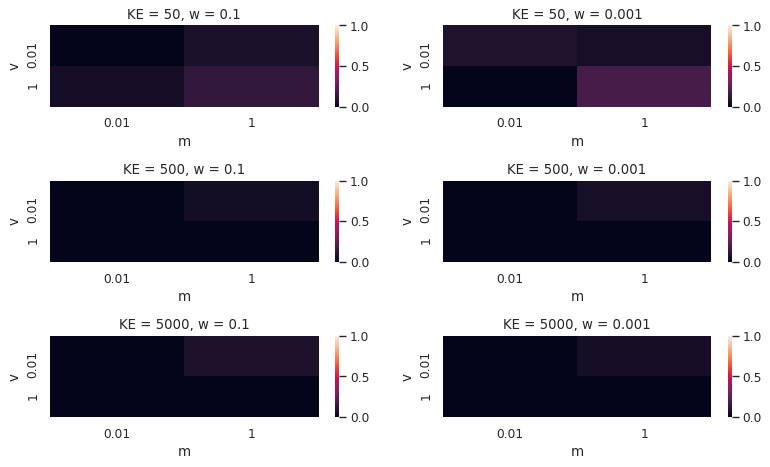

In [6]:
## Study parameters for fraction of host-associated microbes in bound state
KErat = [0.1, 1, 10]
wvals = [0.1, 0.001]
mvals = [0.01, 1]
vvals = [0.01,  1]

Parameters = { 'KH' : 50000,      # Carrying capacity in H
               'mu' : 0.1,      # microbe mutation rate
               'sim_time' : 500,  # total simulation time
               'rep' : 5   # number of replications
             }

def plot_mv(mvals, vvals):
    mat = np.zeros(shape=(len(mvals),len(vvals)))
    for i in range(len(mvals)):
        for j in range(len(vvals)):
            Parameters['mH'] = mvals[i]
            Parameters['v'] = vvals[j]
            repsum = 0
            for n in range(Parameters['rep']):
                data = run_one_sim_get_fracH1(Parameters)
                repsum+=data[-1]
            avg = repsum/Parameters['rep']
            mat[i][j] = avg
    sns.heatmap(mat, yticklabels=mvals, xticklabels=vvals, vmin=0, vmax=1)
    plt.ylabel('v')
    plt.xlabel('m')

fig = plt.figure(figsize=(10, 6), dpi=80)
for k in range(len(KErat)):
    for l in range(len(wvals)):
        KE = int(Parameters['KH']*KErat[k])
        Parameters['w'] = wvals[l]
        
        pos = 100*len(KErat) + 10*len(wvals) + k*len(wvals)+l+1
        plt.subplot(pos)
        
        plot_mv(mvals, vvals)
        plt.title('KE = {}, w = {}'.format(KE, w))

plt.tight_layout()
plt.save_fig('frac')

In [ ]:
## Study parameters for mean M01 value
KErat = [0.1, 1, 10]
wvals = [0.1, 0.001]
mvals = [0.01, 1]
vvals = [0.01,  1]

Parameters = { 'KH' : 50000,      # Carrying capacity in H
               'mu' : 0.1,      # microbe mutation rate
               'sim_time' : 500,  # total simulation time
               'rep' : 10
             }

def plot_mv(mvals, vvals):
    mat = np.zeros(shape=(len(mvals),len(vvals)))
    for i in range(len(mvals)):
        for j in range(len(vvals)):
            Parameters['mH'] = mvals[i]
            Parameters['v'] = vvals[j]
            repsum = 0
            for n in range(Parameters['rep']):
                data = run_one_sim_get_M(Parameters)
                repsum+=data[-1][0]
            avg = repsum/Parameters['rep']
            mat[i][j] = avg
    sns.heatmap(mat, yticklabels=mvals, xticklabels=vvals, vmin=0, vmax=1)
    plt.ylabel('v')
    plt.xlabel('m')

fig = plt.figure(figsize=(10, 6), dpi=80)
for k in range(len(KErat)):
    for l in range(len(wvals)):
        KE = int(Parameters['KH']*KErat[k])
        Parameters['w'] = wvals[l]
        
        pos = 100*len(KErat) + 10*len(wvals) + k*len(wvals)+l+1
        plt.subplot(pos)
        
        plot_mv(mvals, vvals)
        plt.title('KE = {}, w = {}'.format(KE, w))

plt.tight_layout()

In [ ]:
## Study parameters for mean M10 value
KErat = [0.1, 1, 10]
wvals = [0.1, 0.001]
mvals = [0.01, 1]
vvals = [0.01,  1]

Parameters = { 'KH' : 50000,      # Carrying capacity in H
               'mu' : 0.1,      # microbe mutation rate
               'sim_time' : 500,  # total simulation time
               'rep' : 10
             }

def plot_mv(mvals, vvals):
    mat = np.zeros(shape=(len(mvals),len(vvals)))
    for i in range(len(mvals)):
        for j in range(len(vvals)):
            Parameters['mH'] = mvals[i]
            Parameters['v'] = vvals[j]
            repsum = 0
            for n in range(Parameters['rep']):
                data = run_one_sim_get_M(Parameters)
                repsum+=data[-1][1]
            avg = repsum/Parameters['rep']
            mat[i][j] = avg
    sns.heatmap(mat, yticklabels=mvals, xticklabels=vvals, vmin=0, vmax=1)
    plt.ylabel('v')
    plt.xlabel('m')

fig = plt.figure(figsize=(10, 6), dpi=80)
for k in range(len(KErat)):
    for l in range(len(wvals)):
        KE = int(Parameters['KH']*KErat[k])
        Parameters['w'] = wvals[l]
        
        pos = 100*len(KErat) + 10*len(wvals) + k*len(wvals)+l+1
        plt.subplot(pos)
        
        plot_mv(mvals, vvals)
        plt.title('KE = {}, w = {}'.format(KE, w))

plt.tight_layout()

In [69]:
## Parameters

Parameters = { 'KH' : 50000,      # Carrying capacity in H
               'KE' : 50000,      # Carrying capacity in environment
               'mH' : 0.005,       # fraction of host matrix displaced during a flow event
               'v'  : 0.01,       # frequency of flow events
               'w'  : 0.1,      # magnitude of cost of adhesion to host
               'mu' : 0.1,      # microbe mutation rate
               'sim_time' : 2000,  # total simulation time
               'rep' : 10
             }

def run_one_sim_get_timeseries(Parameters):
    # read parameters
    parameters_to_global_variables(Parameters)
    
    H0, H1, E = initialize()
    dataNH1 = []
    dataNH0 = []
    dataNE = []
    dataM01 = []
    dataM10 = []
    for num in range(rep):
        data = []
        for t in range(sim_time):
            vrand = random.random()
            if vrand < v:
                H0, E = flow(H0, E)
            H0, H1 = adhesion(H0, H1)
            H0, H1 = selection_in_host(H0, H1)
            E = env_dynamics(E)
            NH = len(H0[0]) + len(H1[0])
            
            M01, M10 = np.mean(np.r_[H0[0],H1[0],E[0]]).round(2), np.mean(np.r_[H0[1],H1[1],E[1]]).round(2)
            
            data.append([len(H1[0]), len(H0[0]), len(E[0]), M01, M10])
    
        dataNH1.append(np.array(data)[:,0].tolist())
        dataNH0.append(np.array(data)[:,1].tolist())
        dataNE.append(np.array(data)[:,2].tolist())
        dataM01.append(np.array(data)[:,3].tolist())
        dataM10.append(np.array(data)[:,4].tolist())
        
        print('repetation {} done'.format(num))
    return(dataNH1, dataNH0, dataNE, dataM01, dataM10)

dataNH1, dataNH0, dataNE, dataM01, dataM10 = run_one_sim_get_timeseries(Parameters)

repetation 0 done
repetation 1 done
repetation 2 done
repetation 3 done
repetation 4 done
repetation 5 done
repetation 6 done
repetation 7 done
repetation 8 done
repetation 9 done


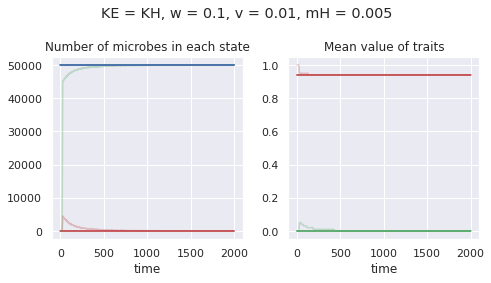

In [70]:
plt.figure(figsize=(7,4))

plt.subplot(121)
plt.plot(np.array(dataNH1).T, 'r', alpha=0.3)
plt.plot(np.array(dataNH0).T, 'g', alpha=0.3)
plt.plot(np.array(dataNE).T, 'b', alpha=0.3)
plt.xlabel('time')
plt.title('Number of microbes in each state')

plt.subplot(122)
plt.plot(np.array(dataM01).T, 'g', alpha=0.3)
plt.plot(np.array(dataM10).T, 'r', alpha=0.3)
plt.xlabel('time')
plt.title('Mean value of traits')

plt.suptitle('KE = KH, w = 0.1, v = 0.01, mH = 0.005')

plt.tight_layout()

In [54]:
np.array([0.3333,0.4444]).round(2)

array([0.33, 0.44])

In [6]:
import numpy as np
np.logspace(0,1,10)

array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ])